1. https://stackoverflow.com/questions/36172913/opencv-depth-map-from-uncalibrated-stereo-system
2. https://github.com/jagracar/OpenCV-python-tests/find/master
3. https://vision.middlebury.edu/stereo/data/

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


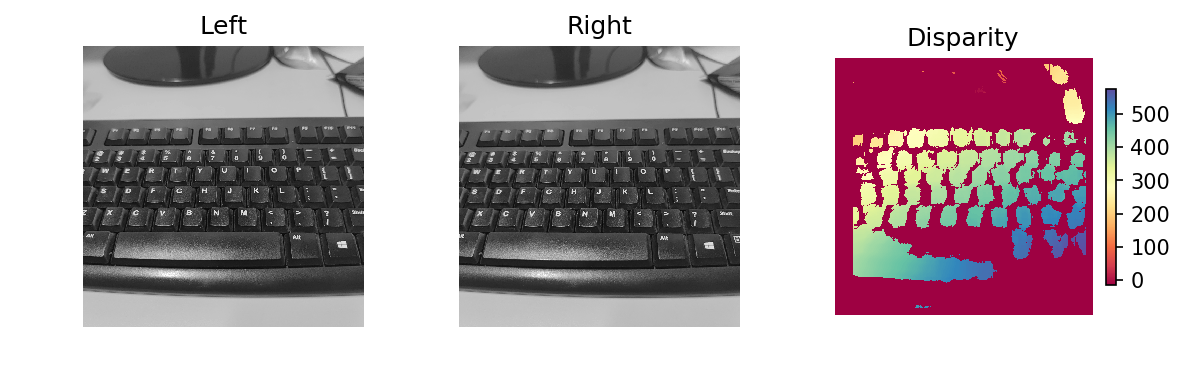

In [197]:
%matplotlib inline

imgL = cv2.imread("im1.jpg", cv2.IMREAD_GRAYSCALE)  # left image
imgR = cv2.imread("im2.jpg", cv2.IMREAD_GRAYSCALE)  # right image

stereo = cv2.StereoBM_create(numDisparities=48, blockSize=61)
disparity = stereo.compute(imgL, imgR)

plt.figure(figsize = (8,4), dpi = 150)
plt.subplot(131)
plt.imshow(imgL, cmap = 'gray')
plt.title("Left")
plt.axis("off")
plt.subplot(132)
plt.imshow(imgR, cmap = 'gray')
plt.title("Right")
plt.axis("off")
plt.subplot(133)
plt.imshow(disparity, cmap = 'Spectral')
plt.title("Disparity")
plt.axis("off")
plt.colorbar(fraction=0.035)
plt.tight_layout()


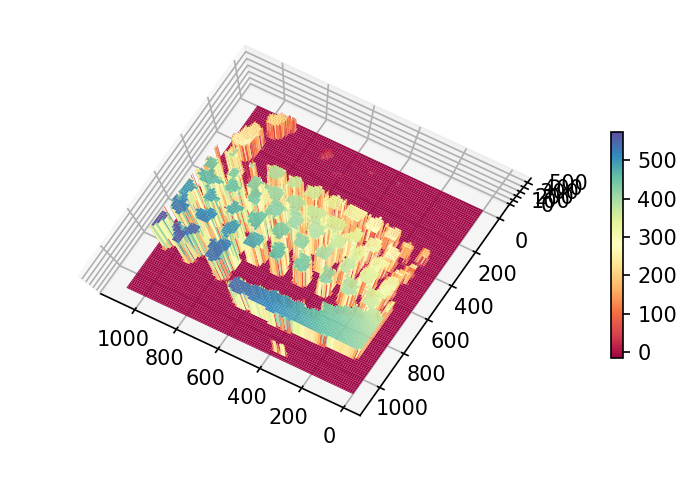

In [3]:
%matplotlib inline
plt.figure(figsize = (6,4), dpi = 150)
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(range(len(disparity)), range(len(disparity)))
p = ax.plot_surface(X, Y, disparity, cmap = 'Spectral', rstride=10, cstride=10)
ax.view_init(elev = 85,azim=120)
plt.colorbar(p, shrink = 0.5)
plt.show()

In [4]:
imgL = cv2.imread("tsukuba_l.png", cv2.IMREAD_GRAYSCALE)  # left image
imgR = cv2.imread("tsukuba_r.png", cv2.IMREAD_GRAYSCALE)  # right image

'https://github.com/jagracar/OpenCV-python-tests/find/master'

'https://github.com/jagracar/OpenCV-python-tests/find/master'

## Keypoints & Descriptors

In [5]:
def get_keypoints_and_descriptors(imgL, imgR):
    """Use ORB detector and FLANN matcher to get keypoints, descritpors,
    and corresponding matches that will be good for computing
    homography.
    """
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(imgL, None)
    kp2, des2 = orb.detectAndCompute(imgR, None)

    ############## Using FLANN matcher ##############
    # Each keypoint of the first image is matched with a number of
    # keypoints from the second image. k=2 means keep the 2 best matches
    # for each keypoint (best matches = the ones with the smallest
    # distance measurement).
    FLANN_INDEX_LSH = 6
    index_params = dict(
        algorithm=FLANN_INDEX_LSH,
        table_number=6,  # 12
        key_size=12,  # 20
        multi_probe_level=1,
    )  # 2
    search_params = dict(checks=50)  # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    flann_match_pairs = flann.knnMatch(des1, des2, k=2)
    return kp1, des1, kp2, des2, flann_match_pairs

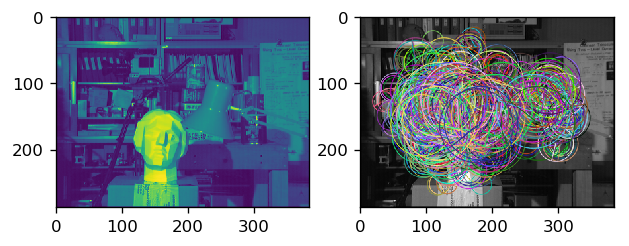

In [55]:
kp1, des1, kp2, des2, flann_match_pairs = get_keypoints_and_descriptors(imgL, imgR)
mg = cv2.drawKeypoints(imgL ,
                      kp1 ,
                      imgL ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(dpi = 120)
plt.subplot(121)
plt.imshow(imgL)
plt.subplot(122)
plt.imshow(mg)

## Drawing Matches

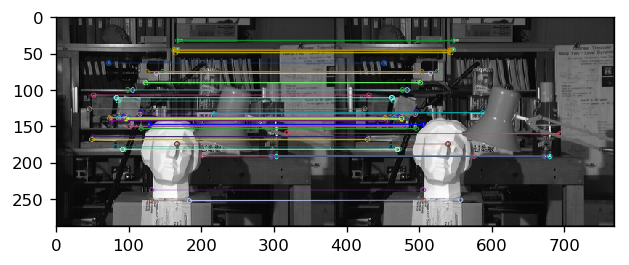

(<matplotlib.image.AxesImage at 0xdc3bcaccf8>, None)

In [56]:
ratio_threshold = 0.6
matches = []
for m, n in flann_match_pairs:
    if m.distance < ratio_threshold * n.distance:
        matches.append(m)

matched_img = cv2.drawMatches(imgL, kp1, imgR, kp2, matches[:50], imgR, flags=2)
plt.figure(dpi = 120)
plt.imshow(matched_img), plt.show()

In [57]:
def lowes_ratio_test(matches, ratio_threshold=0.6):
    """Filter matches using the Lowe's ratio test.

    The ratio test checks if matches are ambiguous and should be
    removed by checking that the two distances are sufficiently
    different. If they are not, then the match at that keypoint is
    ignored.

    https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    """
    filtered_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            filtered_matches.append(m)
    return filtered_matches

In [58]:
def draw_matches(imgL, imgR, kp1, des1, kp2, des2, flann_match_pairs):
    """Draw the first 8 matches between the left and right images."""
    # https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html
    # https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html
    img = cv2.drawMatches(
        imgL,
        kp1,
        imgR,
        kp2,
        flann_match_pairs[:50],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    cv2.imshow("Matches", img)
    cv2.imwrite("ORB_FLANN_Matches.png", img)
    cv2.waitKey(0)


## Fundamental Matrix

In [61]:
method=cv2.FM_RANSAC
pts1, pts2 = [], []
fundamental_matrix, inliers = None, None
for m in matches:
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
if pts1 and pts2:
    # You can play with the Threshold and confidence values here
    # until you get something that gives you reasonable results. I
    # used the defaults
    fundamental_matrix, inliers = cv2.findFundamentalMat(
        np.float32(pts1),
        np.float32(pts2),
        method=method,
#             ransacReprojThreshold=5,
#             confidence=0.99,
    )

In [62]:
fundamental_matrix

array([[ 2.75680930e-05,  3.71694407e-03, -4.12203297e-01],
       [-3.58339827e-03,  9.47343141e-05,  2.06832091e-01],
       [ 3.88659600e-01, -2.22439156e-01,  1.00000000e+00]])

In [63]:
def compute_fundamental_matrix(matches, kp1, kp2, method=cv2.FM_RANSAC):
    """Use the set of good mathces to estimate the Fundamental Matrix.

    See  https://en.wikipedia.org/wiki/Eight-point_algorithm#The_normalized_eight-point_algorithm
    for more info.
    """
    pts1, pts2 = [], []
    fundamental_matrix, inliers = None, None
    for m in matches:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    if pts1 and pts2:
        # You can play with the Threshold and confidence values here
        # until you get something that gives you reasonable results. I
        # used the defaults
        fundamental_matrix, inliers = cv2.findFundamentalMat(
            np.float32(pts1),
            np.float32(pts2),
            method=method,
#             ransacReprojThreshold=5,
#             confidence=0.99,
        )
    return fundamental_matrix, inliers, pts1, pts2

## Calculate Disparity

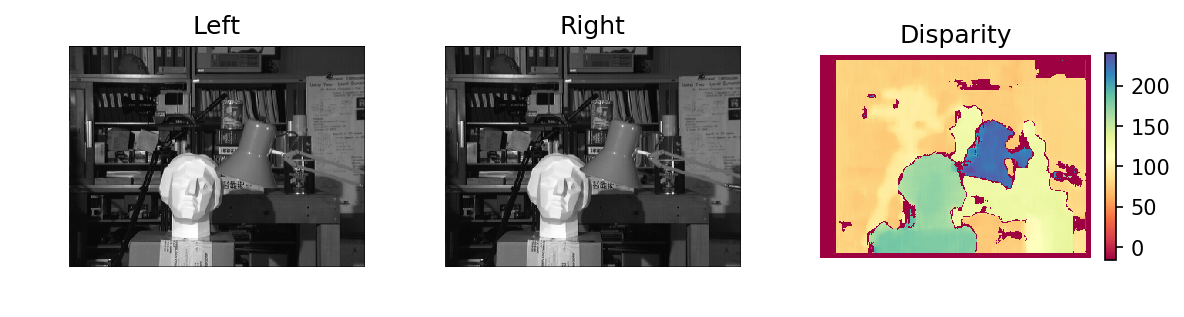

In [13]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL, imgR)

plt.figure(figsize = (8,4), dpi = 150)
plt.subplot(131)
plt.imshow(imgL, cmap = 'gray')
plt.title("Left")
plt.axis("off")
plt.subplot(132)
plt.imshow(imgR, cmap = 'gray')
plt.title("Right")
plt.axis("off")
plt.subplot(133)
plt.imshow(disparity, cmap = 'Spectral')
plt.title("Disparity")
plt.axis("off")
plt.colorbar(fraction=0.035)
plt.tight_layout()

## Stereo Rectify Uncalibrated

In [14]:
h1, w1 = imgL.shape
h2, w2 = imgR.shape
thresh = 0
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1), threshold=thresh,
)

imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))

## StereoBM (Block Matching)

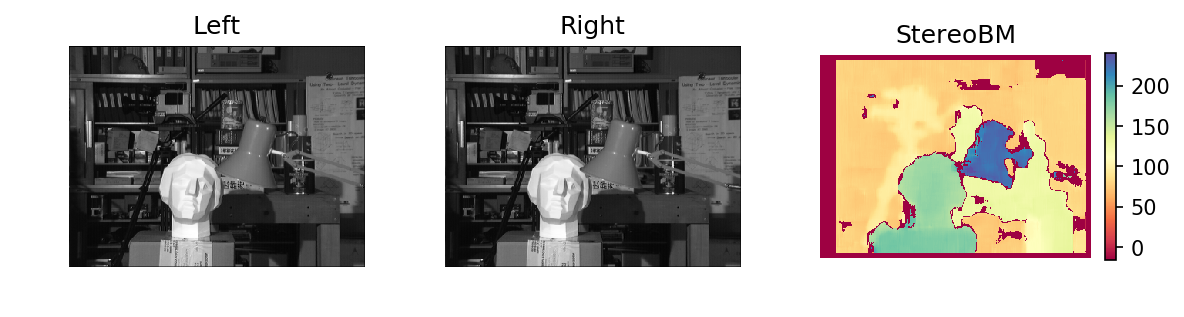

In [22]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_BM = stereo.compute(imgL, imgR)

plt.figure(figsize = (8,4), dpi = 150)
plt.subplot(131)
plt.imshow(imgL, cmap = 'gray')
plt.title("Left")
plt.axis("off")
plt.subplot(132)
plt.imshow(imgR, cmap = 'gray')
plt.title("Right")
plt.axis("off")
plt.subplot(133)
plt.imshow(disparity_BM, cmap = 'Spectral')
plt.title("StereoBM")
plt.axis("off")
plt.colorbar(fraction=0.035)
plt.tight_layout()

## StereoSGBM  (Semi-Global Block Matching)


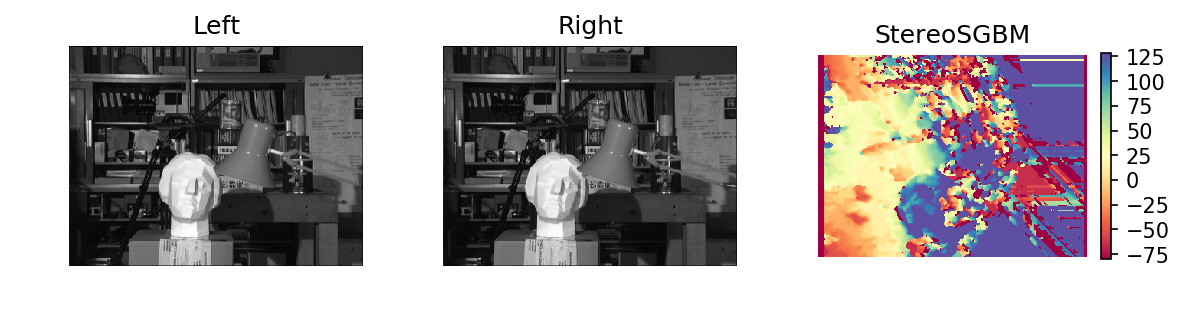

In [23]:
win_size = 2
min_disp = -4
max_disp = 9
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)

plt.figure(figsize = (8,4), dpi = 150)
plt.subplot(131)
plt.imshow(imgL, cmap = 'gray')
plt.title("Left")
plt.axis("off")
plt.subplot(132)
plt.imshow(imgR, cmap = 'gray')
plt.title("Right")
plt.axis("off")
plt.subplot(133)
plt.imshow(disparity_SGBM, cmap = 'Spectral')
plt.title("StereoSGBM")
plt.axis("off")
plt.colorbar(fraction=0.035)
plt.tight_layout()


# Main Function

In [64]:
%matplotlib inline

def Shape_From_Stereo(imgL, imgR, numDisparities, blockSize):
    ############## Find good keypoints to use ##############
    kp1, des1, kp2, des2, flann_match_pairs = get_keypoints_and_descriptors(imgL, imgR)
    good_matches = lowes_ratio_test(flann_match_pairs, 0.2)
#     draw_matches(imgL, imgR, kp1, des1, kp2, des2, good_matches)

    ############## Compute Fundamental Matrix ##############
    F, I, points1, points2 = compute_fundamental_matrix(good_matches, kp1, kp2)

    ############## Stereo rectify uncalibrated ##############
    h1, w1 = imgL.shape
    h2, w2 = imgR.shape
    thresh = 0
    _, H1, H2 = cv2.stereoRectifyUncalibrated(
        np.float32(points1), np.float32(points2), F, imgSize=(w1, h1), threshold=thresh,
    )

    ############## Undistort (Rectify) ##############
    imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
    imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))

    ############## Calculate Disparity (Depth Map) ##############

    # Using StereoBM
    stereo = cv2.StereoBM_create(numDisparities, blockSize)
    disparity = stereo.compute(imgL, imgR)

    disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)

    # Using StereoSGBM
    # Set disparity parameters. Note: disparity range is tuned according to
    #  specific parameters obtained through trial and error.
    win_size = 2
    min_disp = -4
    max_disp = 9
    num_disp = max_disp - min_disp  # Needs to be divisible by 16
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=5,
        uniquenessRatio=5,
        speckleWindowSize=5,
        speckleRange=5,
        disp12MaxDiff=2,
        P1=8 * 3 * win_size ** 2,
        P2=32 * 3 * win_size ** 2,
    )
    disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)

    plt.figure(figsize = (8,4), dpi = 150)
    plt.subplot(131)
    plt.imshow(disparity, cmap = 'Spectral')
    plt.title("Disparity")
    plt.axis("off")
    plt.colorbar(fraction=0.035)
    plt.tight_layout()

    plt.subplot(132)
    plt.imshow(disparity_BM, cmap = 'Spectral')
    plt.title("StereoBM")
    plt.axis("off")
    plt.colorbar(fraction=0.035)
    plt.tight_layout()

    plt.subplot(133)
    plt.imshow(disparity_SGBM, cmap = 'Spectral')
    plt.title("StereoSGBM")
    plt.axis("off")
    plt.colorbar(fraction=0.035)
    plt.tight_layout()
    
    return disparity, disparity_BM, disparity_SGBM

## 3D Plotter

In [79]:
def plot_3D(disparity, elev,azim):
    plt.figure(figsize = (6,4), dpi = 150)
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(range(disparity.shape[1]), range(disparity.shape[0]))
    p = ax.plot_surface(-X, Y, disparity, cmap = 'Spectral', rstride=5, cstride=5)
    ax.view_init(elev=elev,azim=azim)
    plt.colorbar(p, shrink = 0.5)
    plt.show()

# Results: Stereo Datasets

## Tsukuba

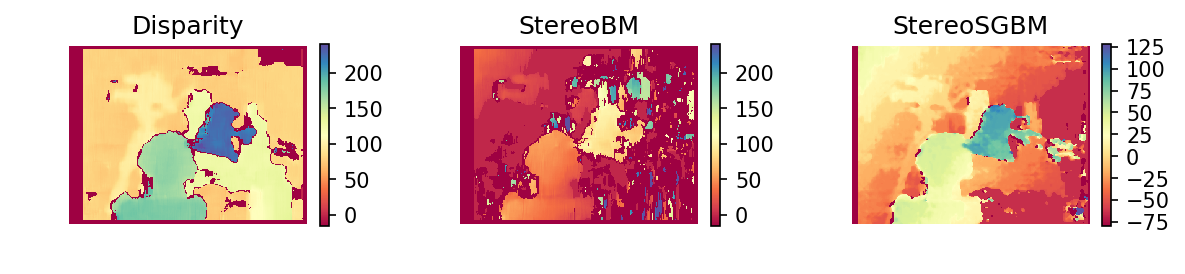

In [172]:
d1, d1_bm, d1_sgbm = Shape_From_Stereo(
    cv2.imread("tsukuba_l.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("tsukuba_r.png", cv2.IMREAD_GRAYSCALE),
    numDisparities = 16, blockSize = 15)

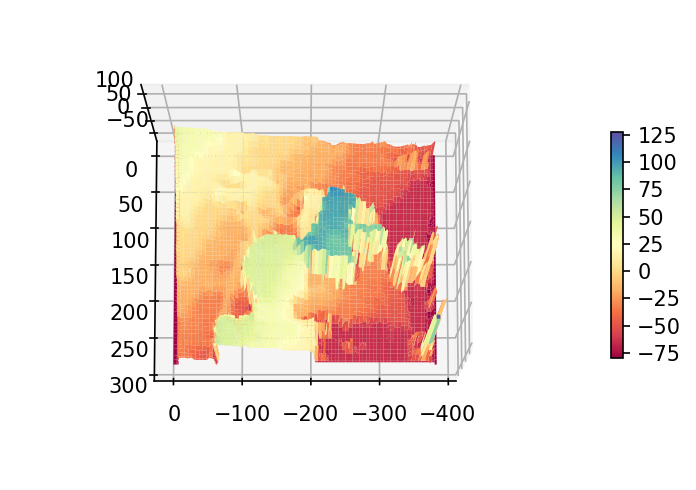

In [173]:
plot_3D(d1_sgbm, elev = 80,azim = 90)

## Cones

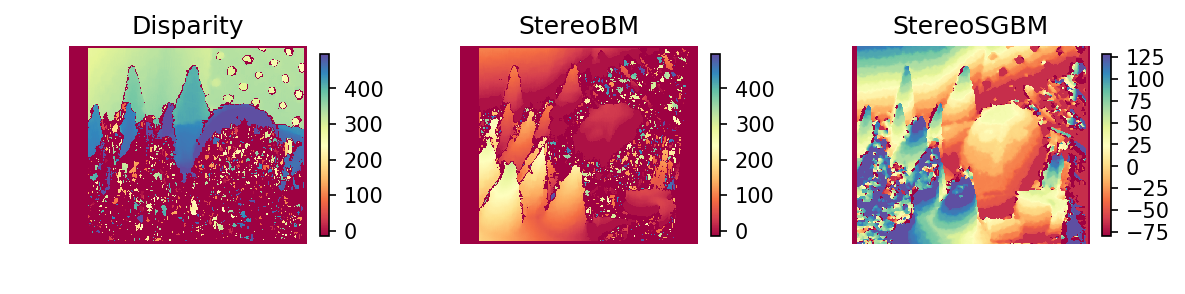

In [178]:
d2, d2_bm, d2_sgbm  = Shape_From_Stereo(
    cv2.imread("cones1.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("cones2.png", cv2.IMREAD_GRAYSCALE),
     numDisparities = 32, blockSize = 11)

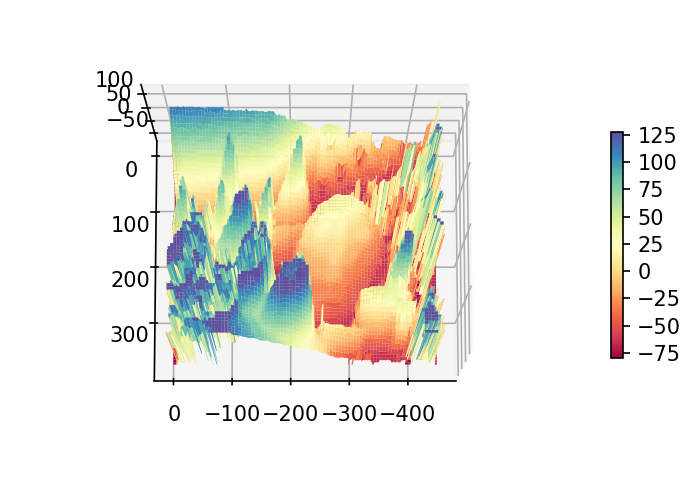

In [179]:
plot_3D(d2_sgbm, elev = 80,azim = 90)

## Art

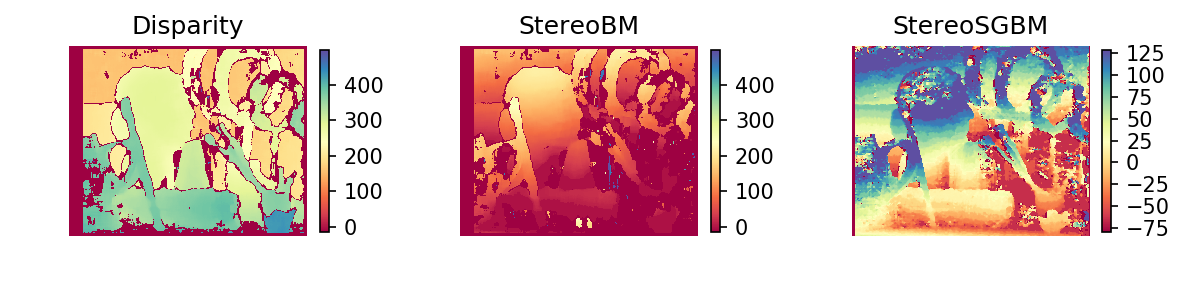

In [180]:
d3, d3_bm, d3_sgbm = Shape_From_Stereo(
    cv2.imread("art1.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("art2.png", cv2.IMREAD_GRAYSCALE),
    numDisparities = 32, blockSize = 21)

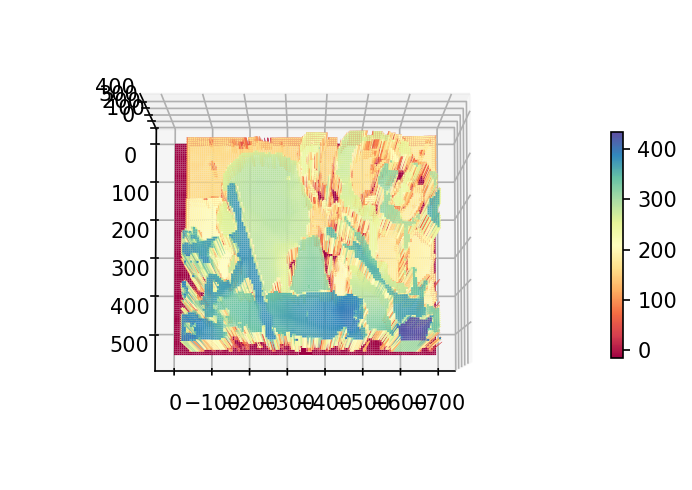

In [189]:
plot_3D(d3, elev = 85,azim = 90)

## Aloe Vera

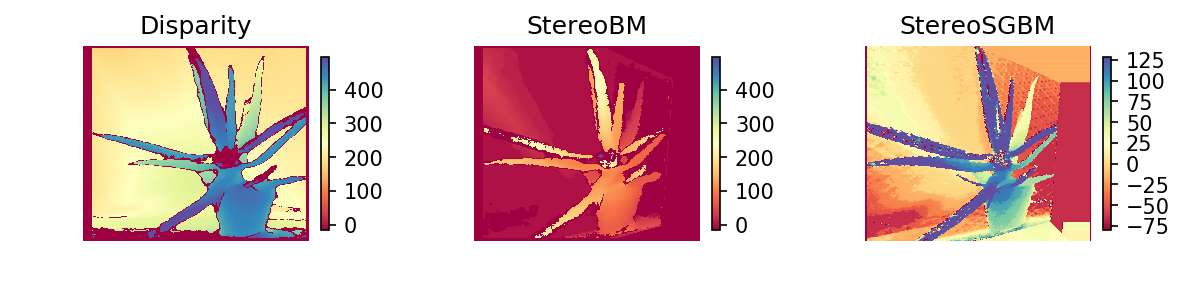

In [190]:
d4, d4_bm, d4_sgbm = Shape_From_Stereo(
    cv2.imread("aloe.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("aloe1.png", cv2.IMREAD_GRAYSCALE),
    numDisparities = 32, blockSize = 39)

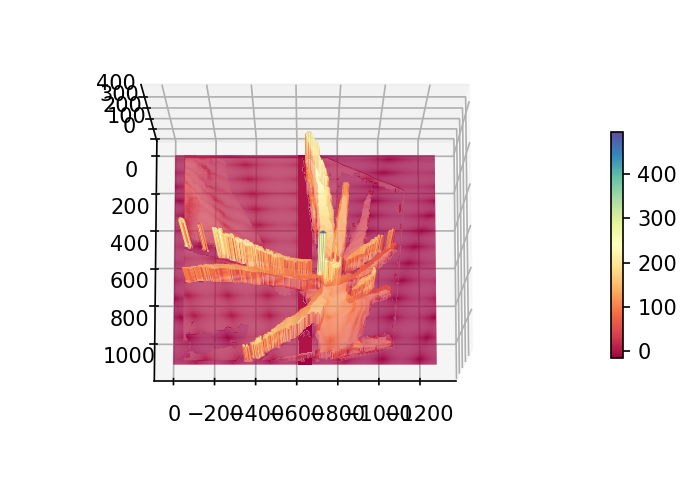

In [191]:
plot_3D(d4_bm, elev = 80,azim = 90)

# Results: Own images

## Keyboard

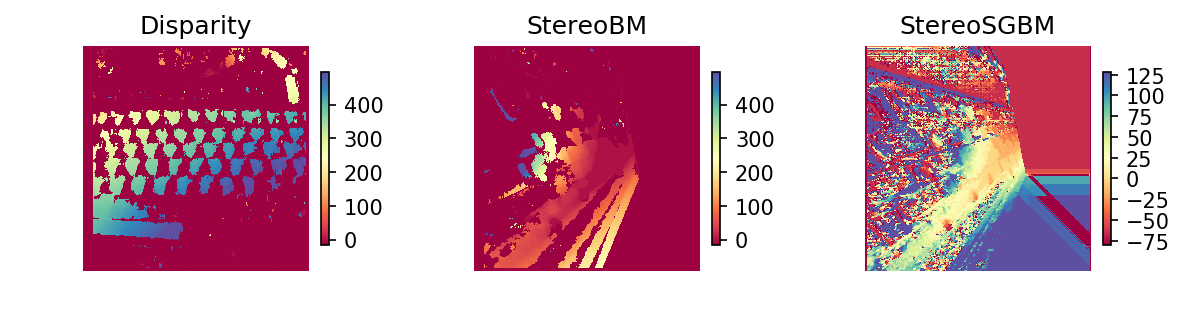

In [194]:
d6, d6_bm, d6_sgbm = Shape_From_Stereo(
    cv2.imread("im1.jpg", cv2.IMREAD_GRAYSCALE),
    cv2.imread("im2.jpg", cv2.IMREAD_GRAYSCALE),
    numDisparities = 32, blockSize = 31)

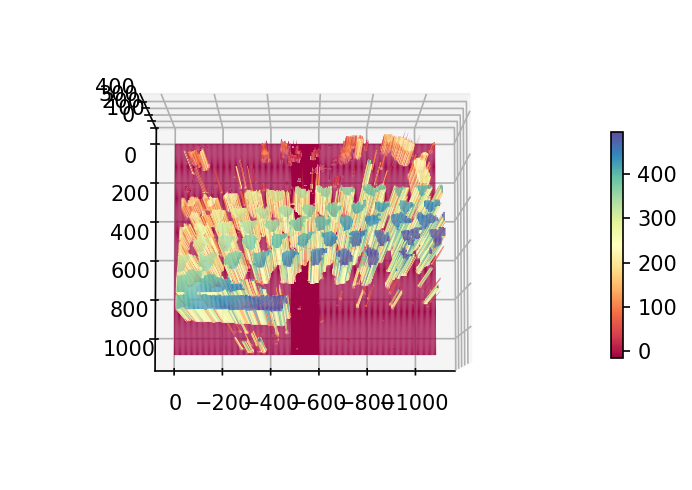

In [196]:
plot_3D(d6, elev = 85,azim = 90)

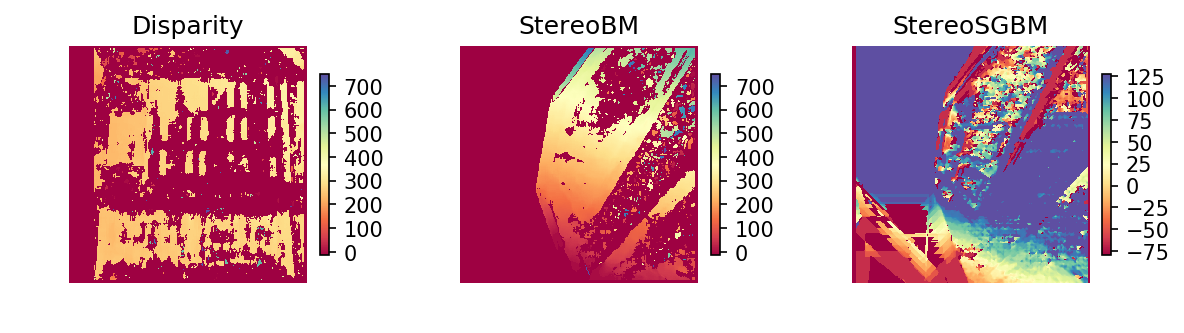

In [109]:
d2, d2_bm, d2_sgbm = Shape_From_Stereo(
    cv2.imread("test1.jpg", cv2.IMREAD_GRAYSCALE),
    cv2.imread("test2.jpg", cv2.IMREAD_GRAYSCALE),
    numDisparities = 48, blockSize = 15)

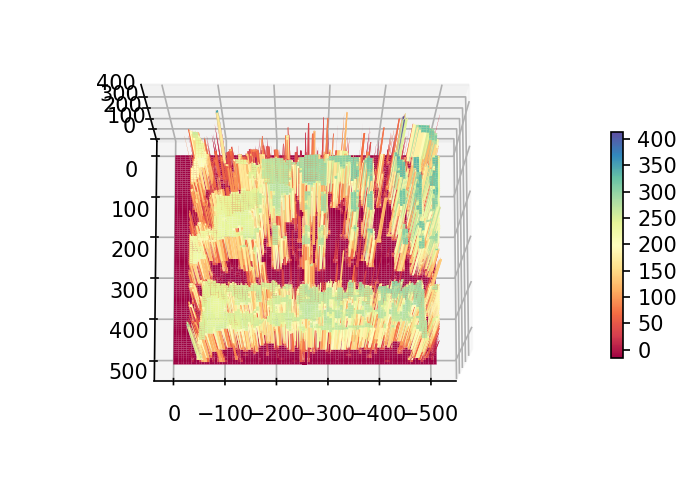

In [108]:
plot_3D(d2, elev = 80,azim = 90)

In [111]:
disparity, disparity_BM, disparity_SGBM = Shape_From_Stereo(
    cv2.imread("jade1.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("jade2.png", cv2.IMREAD_GRAYSCALE),
    numDisparities = 32, blockSize = 11)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-czu11tvl\opencv\modules\core\src\convert_c.cpp:113: error: (-215:Assertion failed) src.size == dst.size && src.channels() == dst.channels() in function 'cvConvertScale'


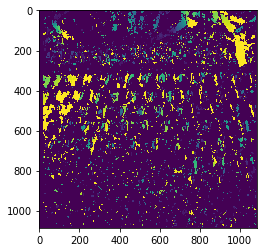

<IPython.core.display.Javascript object>


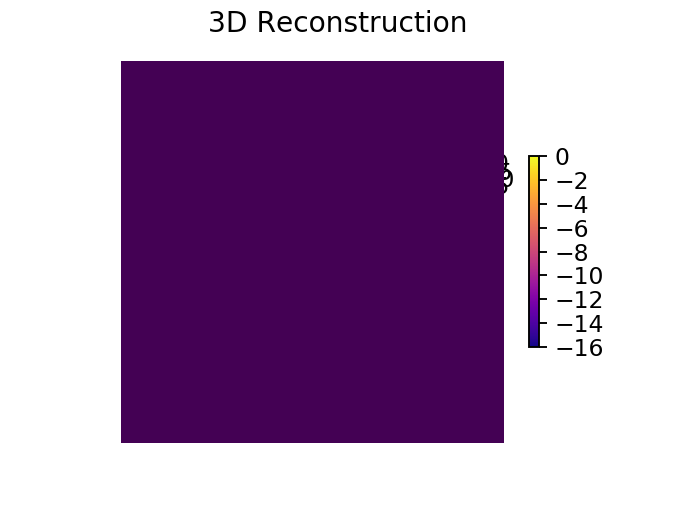

In [157]:
%matplotlib notebook

X,Y = np.meshgrid(range(len(disparity_BM)), range(len(disparity_BM)))

fig = plt.figure(figsize = [4,3], dpi = 150)
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("3D Reconstruction")

p = ax.plot_surface(X, Y, disparity_BM, cmap = 'plasma', rstride=10, cstride=10)
ax.view_init(elev = 25,azim=30)
plt.colorbar(p, shrink = 0.5)
plt.show()

In [141]:
Shape_From_Stereo(cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE),
                  cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE))

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-czu11tvl\opencv\modules\calib3d\src\calibration.cpp:2820: error: (-215:Assertion failed) CV_IS_MAT(_points1) && CV_IS_MAT(_points2) && CV_ARE_SIZES_EQ(_points1, _points2) in function 'cvStereoRectifyUncalibrated'


In [ ]:


# imgL = cv2.imread("im1.jpg", cv2.IMREAD_GRAYSCALE)  # left image
# imgR = cv2.imread("im2.jpg", cv2.IMREAD_GRAYSCALE)  # right image

# imgL = cv2.imread("test1.jpg", cv2.IMREAD_GRAYSCALE)  # left image
# imgR = cv2.imread("test2.jpg", cv2.IMREAD_GRAYSCALE)  # right image

# imgL = cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE)  # left image
# imgR = cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE)  # right image

imgL = cv2.imread("tsukuba_l.png", cv2.IMREAD_GRAYSCALE)  # left image
imgR = cv2.imread("tsukuba_r.png", cv2.IMREAD_GRAYSCALE)  # right image

<IPython.core.display.Javascript object>


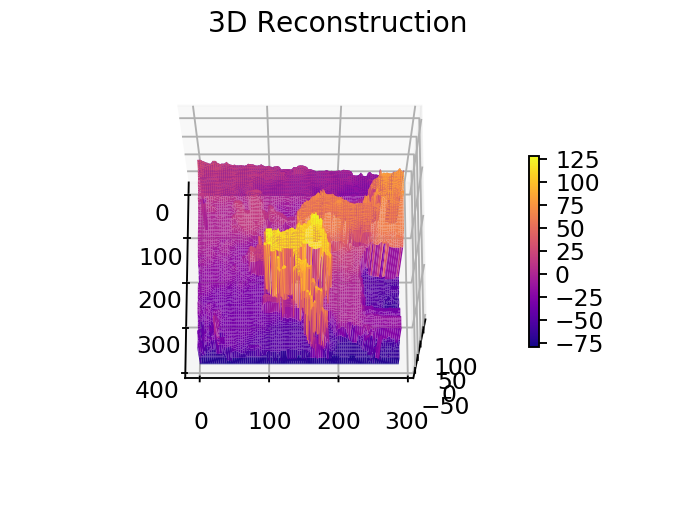

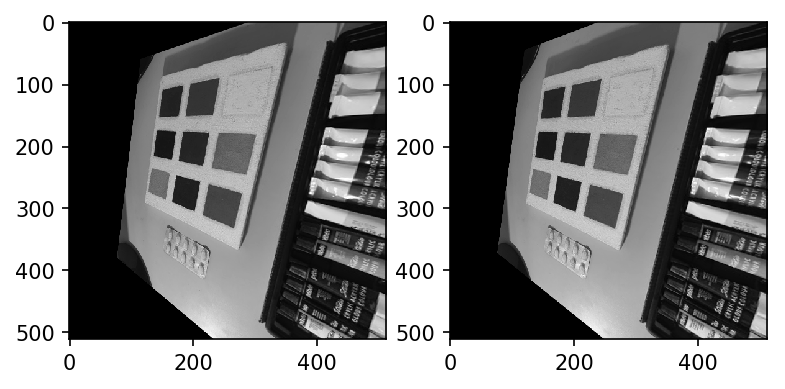

In [13]:
plt.figure(dpi = 150)
plt.subplot(121)
plt.imshow(imgL_undistorted,'gray')
plt.subplot(122)
plt.imshow(imgR_undistorted,'gray')


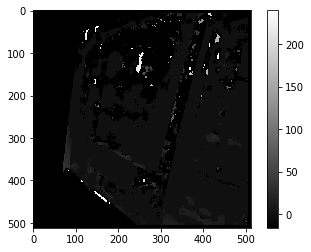

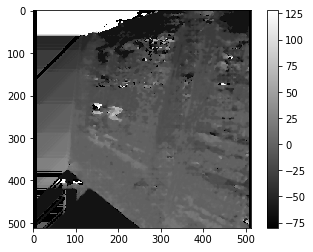

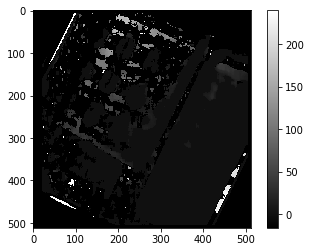

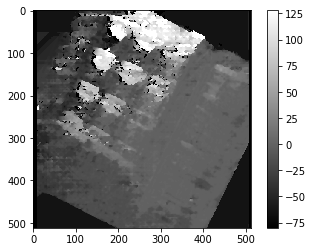

In [9]:
############## Calculate Disparity (Depth Map) ##############

# Using StereoBM
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM, "gray")
plt.colorbar()
plt.show()

# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 2
min_disp = -4
max_disp = 9
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM, "gray")
plt.colorbar()
plt.show()